In [11]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [12]:
IMG_WIDTH = 216
IMG_HEIGHT = 250
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset (Ovarian Cancer)",
    shuffle=True,
    image_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE
)

Found 987 files belonging to 2 classes.


In [14]:
class_names = dataset.class_names
class_names

['Ovarian_Cancer', 'Ovarian_Non_Cancer']

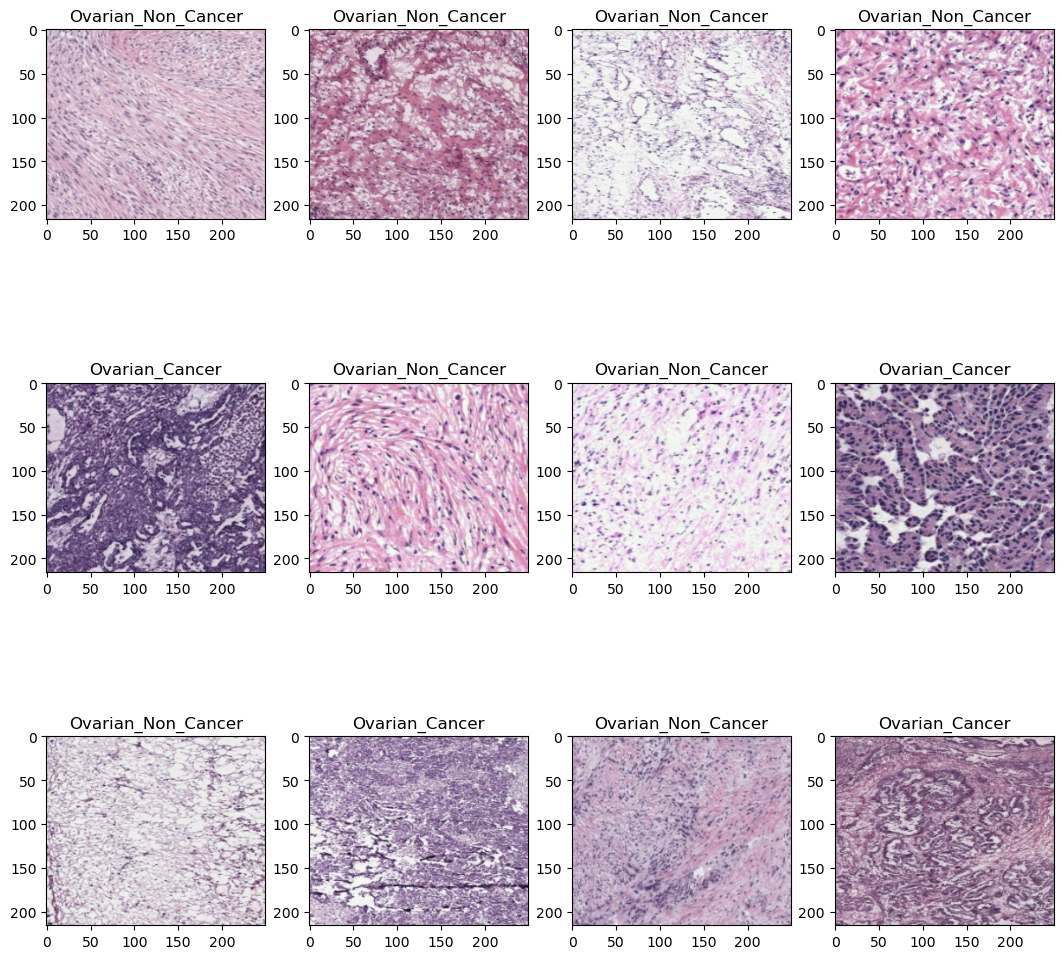

In [15]:
plt.figure(figsize=(13,13))
for img, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])

In [16]:
training_size = 0.8
validation_size = 0.1
len(dataset)*training_size

24.8

In [17]:
# training the model with 80% of the dataset
training_dataset = dataset.take(24)
len(training_dataset)

24

In [18]:
test_dataset = dataset.skip(24)
len(test_dataset)

7

In [19]:
len(dataset)*validation_size 

3.1

In [20]:
validation_dataset = test_dataset.take(3)
len(validation_dataset)

3

In [21]:
test_dataset = test_dataset.skip(3)
len(test_dataset)

4

In [22]:
# when cpu or gpu is busy performing training, prefetch will load the next set of batch from the disk

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
# PREPROCESSING
# the RGB array that was in range of 0-225, we need it to be between 0 and 1
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_WIDTH, IMG_HEIGHT),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
# Data Augmentation - while predicting if the images are rotated or are of different contrast, predictions wont be accurate. To handle this, we use data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [26]:
input_shape = (BATCH_SIZE, IMG_WIDTH,IMG_HEIGHT, CHANNELS)
no_of_classes = 3

# parameters : resized, augmentation, convolutional layer, pooling layer ... trial and error
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(no_of_classes, activation = 'softmax')
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 216, 250, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 216, 250, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 214, 248, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 107, 124, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 105, 122, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 52, 61, 64)          0         
 g2D)                                                 

In [28]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [29]:
history = model.fit(
    training_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_dataset
)

Epoch 1/30
24/24 [==============================] - 18s 632ms/step - loss: 0.7712 - accuracy: 0.5117 - val_loss: 0.6988 - val_accuracy: 0.5417
Epoch 2/30
24/24 [==============================] - 14s 588ms/step - loss: 0.6775 - accuracy: 0.5130 - val_loss: 0.6557 - val_accuracy: 0.5417
Epoch 3/30
24/24 [==============================] - 14s 584ms/step - loss: 0.5796 - accuracy: 0.6667 - val_loss: 0.4052 - val_accuracy: 0.8750
Epoch 4/30
24/24 [==============================] - 14s 575ms/step - loss: 0.2492 - accuracy: 0.8958 - val_loss: 0.3146 - val_accuracy: 0.8750
Epoch 5/30
24/24 [==============================] - 14s 577ms/step - loss: 0.2571 - accuracy: 0.9049 - val_loss: 0.2192 - val_accuracy: 0.9479
Epoch 6/30
24/24 [==============================] - 14s 567ms/step - loss: 0.2249 - accuracy: 0.9193 - val_loss: 0.2194 - val_accuracy: 0.9479
Epoch 7/30
24/24 [==============================] - 14s 573ms/step - loss: 0.1389 - accuracy: 0.9479 - val_loss: 0.2956 - val_accuracy: 0.8854

In [37]:
scores = model.evaluate(test_dataset)

4/4 [==============================] - 1s 155ms/step - loss: 0.1122 - accuracy: 0.9512


In [38]:
scores

[0.1121676042675972, 0.9512194991111755]

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Image to predict
the image's actual label :  Ovarian_Non_Cancer
1/1 [==============================] - 0s 166ms/step
the image's predicted label :  Ovarian_Non_Cancer


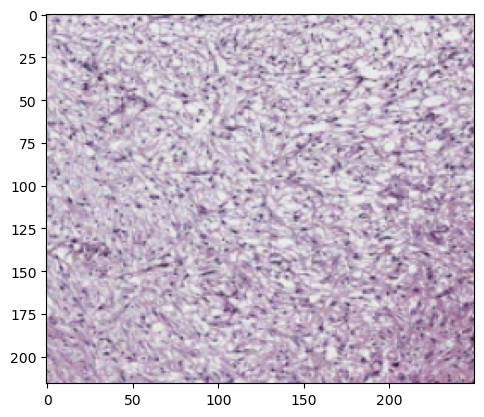

In [41]:
import numpy as np

# make predictions
# first prediction
for img_batch, label_batch in test_dataset.take(1):
    
    first_img = (img_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    
    print("Image to predict")
    plt.imshow(first_img)
    print("the image's actual label : ", class_names[first_label.numpy()])

    batch_prediction = model.predict(img_batch)
    print("the image's predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class =  class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 22ms/step


In [43]:
model_version = 1
model.save(f"../Models/Ovarian/{model_version}")

INFO:tensorflow:Assets written to: ../Models/Ovarian/1\assets


INFO:tensorflow:Assets written to: ../Models/Ovarian/1\assets
